In [1]:
# Imports: standard library
import time

# Imports: third party
import pandas as pd
import os
from tqdm import tqdm
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

# Imports: first party
from optimizer import estimate_ancestry
from loader import twenty_three, load_model
from loader import vcf
from plot import generate_admixture_plot
from models import generate_1000genomes_model

### **Running example**

#### **Importing functions**

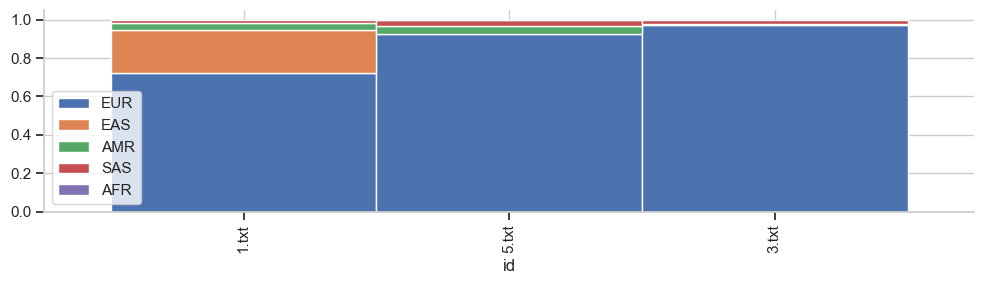

In [2]:
ancestries = {}
model = load_model("1000Genomes_superpopulation")
for sample_file in ["./sample-data/1.txt", "./sample-data/5.txt", "./sample-data/3.txt"]:
    sample_data = twenty_three(sample_file)
    for id, sample in sample_data.items():
        ancestries[id] = estimate_ancestry(sample, model)
data = pd.DataFrame.from_dict(ancestries, orient='index').round(3)
data.index.name = "id"
generate_admixture_plot(data)

#### **From the command line**

In [3]:
%run admixture -i ./sample-data/1.txt ./sample-data/5.txt ./sample-data/3.txt -m 1000Genomes_superpopulation

2024-03-12 22:20:55 - INFO - logger:33 - Logging configuration was loaded. Log messages can be found at None.
2024-03-12 22:20:55 - INFO - admixture:25 - Command line was: 
admixture.py -i ./sample-data/1.txt ./sample-data/5.txt ./sample-data/3.txt -m 1000Genomes_superpopulation
2024-03-12 22:20:55 - INFO - admixture:68 - Loading 3 samples...
2024-03-12 22:20:57 - INFO - admixture:79 - Samples loaded!
2024-03-12 22:20:57 - INFO - admixture:81 - Loading admixture 1000Genomes_superpopulation model...
2024-03-12 22:20:58 - INFO - admixture:83 - Admixture model loaded!
2024-03-12 22:20:58 - INFO - admixture:87 - Estimating sample 1.txt ancestry...
2024-03-12 22:21:24 - INFO - optimizer:101 - Admixture proportions:
	EUR: 72.364%
	EAS: 22.150%
	AMR: 3.716%
	SAS: 1.733%
	AFR: 0.037%
2024-03-12 22:21:24 - INFO - admixture:87 - Estimating sample 5.txt ancestry...
2024-03-12 22:21:48 - INFO - optimizer:101 - Admixture proportions:
	EUR: 92.326%
	EAS: 0.000%
	AMR: 4.420%
	SAS: 3.135%
	AFR: 0.119%

### **Reproduce PS2 Admixture problem**

#### **Make Analysis and Figure**

In [4]:
sample_map = pd.read_csv("./ps2-results/igsr_samples.tsv", sep="\t")
sample_map = sample_map[["Sample name", "Population code"]]
sample_map.columns = ["id", "pop"]
sample_map = sample_map.set_index("id")
sample_map = sample_map[sample_map["pop"].isin(["ASW", "CEU", "GWD", "PEL", "PUR"])]
ids = sample_map.index.unique()

In [5]:
data_dict = vcf("./ps2-results/1000G_chr21_pruned.vcf", ids=ids)
model = load_model("1000Genomes_chr21_population")

In [6]:
ancestries = {}
for id, sample_name in tqdm(data_dict.items()):
    ancestries[id] = estimate_ancestry(sample_name, model)

100%|██████████| 462/462 [05:07<00:00,  1.50it/s]


In [7]:
data = pd.DataFrame.from_dict(ancestries, orient='index').round(3)
data.index.name = "id"
data["pop"] = data.index.map(sample_map['pop'])
data.to_csv("./ps2-results/chr21_ancestry_estimation.csv")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


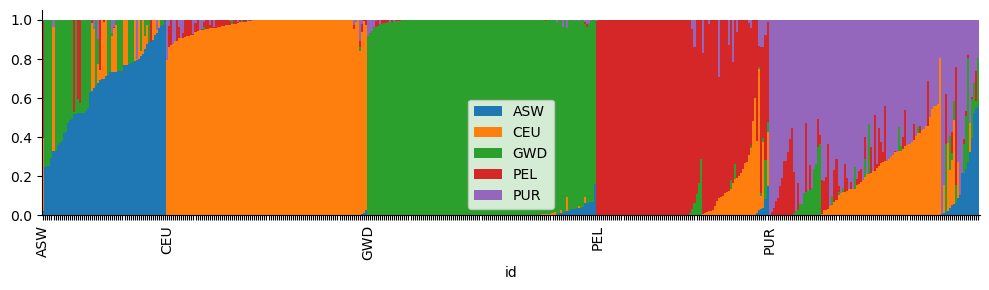

In [8]:
%pylab inline
fig, ax = plt.subplots(figsize=(10, 3))

cols = list(data.columns)[:-1] 
# data['pop'] = data.idxmax(axis=1)
data = data.sort_values(["pop"]+cols)
data.plot.bar(stacked=True, ax=ax, width=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Only plot label for first sample in each pop
xticklabels = []
currpop = ""
for i in range(data.shape[0]):
    if data["pop"].values[i] == currpop:
        xticklabels.append("")
    else:
        xticklabels.append(data["pop"].values[i])
        currpop = data["pop"].values[i]
ax.set_xticklabels(xticklabels)

fig.tight_layout()

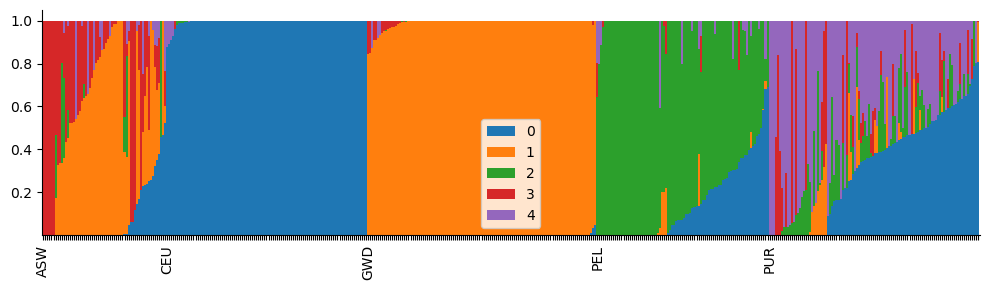

In [9]:
sampleinfo = pd.read_csv("./ps2-results/igsr_samples.tsv", sep="\t")
sample_to_pop = dict(zip(list(sampleinfo["Sample name"]), list(sampleinfo["Population code"])))
samples = [line.split()[0] for line in open("./ps2-results/ps2_admixture.pruned.fam", "r").readlines()]
pops = [sample_to_pop.get(item, "NA") for item in samples]

ps2 = pd.read_csv("./ps2-results/ps2_admixture.pruned.5.Q", delim_whitespace=True, header=None)
cols = list(ps2.columns)
ps2["sample"] = samples
ps2["pop"] = pops
ps2 = ps2.sort_values(["pop"]+cols)

fig, ax = plt.subplots(figsize=(10, 3))
ps2.plot.bar(stacked=True, ax=ax, width=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Only plot label for first sample in each pop
xticklabels = []
currpop = ""
for i in range(data.shape[0]):
    if ps2["pop"].values[i] == currpop:
        xticklabels.append("")
    else:
        xticklabels.append(ps2["pop"].values[i])
        currpop = ps2["pop"].values[i]
ax.set_xticklabels(xticklabels)
fig.tight_layout()

#### **Benchmark running time and memory usage**

In [10]:
sample_map = pd.read_csv("./ps2-results/igsr_samples.tsv", sep="\t")
sample_map = sample_map[["Sample name", "Population code"]]
sample_map.columns = ["id", "pop"]
sample_map = sample_map.set_index("id")
sample_map = sample_map[sample_map["pop"].isin(["ASW", "CEU", "GWD", "PEL", "PUR"])]
ids = sample_map.index.unique()

def run_analysis():
    data_dict = vcf("./ps2-results/1000G_chr21_pruned.vcf", ids=ids)
    model = load_model("1000Genomes_chr21_population")
    ancestries = {}
    for id, sample in tqdm(data_dict.items()):
        ancestries[id] = estimate_ancestry(sample, model)

##### **Algorithm Runtime**

In [11]:
n_times = 4
start = time.time()
for i in range(n_times):
    print(i+1)
    run_analysis()
end = time.time()
print(f"Execution took {(end-start)/60/n_times} minutes on average.")

1


100%|██████████| 462/462 [05:19<00:00,  1.44it/s]


2


100%|██████████| 462/462 [04:44<00:00,  1.63it/s]


3


100%|██████████| 462/462 [04:49<00:00,  1.60it/s]


4


100%|██████████| 462/462 [04:53<00:00,  1.58it/s]


Execution took 5.752693857749303 minutes on average.


##### **Algorithm memory usage**

In [12]:
n_times = 2
peak_memory = []
for i in range(n_times):
    print(i+1)
    mem_usage = memory_usage(run_analysis, max_usage=True)
    peak_memory.append(mem_usage)
print(f"Average peak memory: {sum(peak_memory)/n_times} MiB.")

1


100%|██████████| 462/462 [04:50<00:00,  1.59it/s]


2


100%|██████████| 462/462 [04:42<00:00,  1.63it/s]


Average peak memory: 2817.310546875 MiB.


##### **Model Generation Runtime**

In [13]:
generate_1000genomes_model
n_times = 4
start = time.time()
for i in range(n_times):
    print(i+1)
    generate_1000genomes_model("./ps2-results", "./", chromosomes=[21])
end = time.time()
os.remove("1000Genomes_pop.txt")
os.remove("1000Genomes_superpop.txt")
print(f"Execution took {(end-start)/60/n_times} minutes on average.")

1
Extracting stats for snps in chromosome 21...


13431it [00:58, 227.97it/s]


2
Extracting stats for snps in chromosome 21...


13431it [01:02, 215.22it/s]


3
Extracting stats for snps in chromosome 21...


13431it [01:01, 218.44it/s]


4
Extracting stats for snps in chromosome 21...


13431it [01:02, 215.37it/s]


Execution took 1.032368004322052 minutes on average.


##### **ADMIXTURE Runtime**

To benchmark the ADMIXTURE software you must run the following command within the DataHub environment with k equal to just 5:
```console
time ./ps2_run_admixture.sh
```
Run the command 4 times and average the time.